In [30]:
# ==============================================================================
#  라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
from tqdm.contrib.concurrent import thread_map
import joblib

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA


# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss

# 데이터 관련 
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/cry2003/google-recaptcha-v2-images/versions/1/"
DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/refined/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [28]:
# ==============================================================================
#  데이터 로드 함수
# ==============================================================================

# 이미지 로드 함수
def load_images_from_folder(base_path, img_size=(120, 120)):
    images = []
    labels = []
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"이미지 폴더를 찾을 수 없습니다: {image_folder_path}\n"
                                f"DATASET_BASE_PATH를 올바르게 설정했는지 확인해주세요.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="폴더 로드 중"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
                except Exception as e:
                    print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================================================================
#  이미지 전처리 함수
# ==============================================================================

# 대비 스트레칭
def contrast_stretch(img, p_low=1, p_high=99):
    low, high = np.percentile(img, (p_low, p_high))
    return rescale_intensity(img, in_range=(low, high))

# 그레이스케일 변환
def to_grayscale(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# 히스토그램 평활화
def histogram_equalization(image_gray):
    return equalize_hist(image_gray)

# 노이즈 필터링
def remove_noise(image):
    image = gaussian(image, sigma=1)
    denoised_image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)
    return img_as_ubyte(denoised_image)

def gaussian(image):
    return cv2.GaussianBlur(image, ksize=(3, 3), sigmaX=1)

# 엣지 검출 (Canny)
def edge_detection(image_gray, low_threshold=30, high_threshold=200, aperture_size=3):
    if image_gray.dtype != np.uint8:
        image_gray = cv2.convertScaleAbs(image_gray)
    return cv2.Canny(image_gray, low_threshold, high_threshold, apertureSize=aperture_size)

# 선명화
def sharpen_image(image_gray, low_threshold=50, high_threshold=150, amount=1.0):
    edges = cv2.Canny(image_gray, low_threshold, high_threshold)
    mask = (edges / 255.0).astype(np.float32)
    sharpened = image_gray.astype(np.float32) + amount * (mask * 255.0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

# 전처리 함수
def preprocess_image(img):
    img = to_grayscale(img)
    img = gaussian(img)
    img = contrast_stretch(img)
    img = edge_detection(img)
    return img
print("✔ 이미지 전처리 함수 정의 완료.")

✔ 이미지 전처리 함수 정의 완료.


In [ ]:
# ==============================================================================
#  피쳐 추출 함수
# ==============================================================================

def build_sift_vocabulary(images, n_clusters=200):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for img in tqdm(images, desc="Extracting SIFT descriptors for vocab"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    all_descriptors = np.vstack(all_descriptors)  # (N, 128)
    if len(all_descriptors) == 0:
        raise ValueError("SIFT descriptors를 추출할 수 없습니다. 이미지가 손상되었거나 불러오기에 실패했을 수 있습니다.")

    print(f"✔ 총 {all_descriptors.shape[0]}개의 SIFT descriptors 추출됨.")

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048, n_init='auto')
    kmeans.fit(all_descriptors)
    return kmeans

def extract_bovw_sift_features(image_gray, vocabulary_kmeans):
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)

    if descriptors is None or descriptors.shape[0] == 0:
        # Return a zero vector of the size of the vocabulary if no descriptors found
        return np.zeros(vocabulary_kmeans.n_clusters)

    # Predict the cluster for each descriptor
    visual_words = vocabulary_kmeans.predict(descriptors)

    # Create a histogram of visual words
    bovw_histogram = np.zeros(vocabulary_kmeans.n_clusters)
    for word_index in visual_words:
        bovw_histogram[word_index] += 1

    # Normalize the histogram
    bovw_histogram = bovw_histogram / (np.sum(bovw_histogram) + 1e-7)
    return bovw_histogram

# LBP (Local Binary Pattern) - 기존과 동일
def extract_lbp_features(image_gray, num_points=24, radius=3):
    lbp = local_binary_pattern(image_gray, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist


# HOG (Histogram of Oriented Gradients) - 기존과 동일
def extract_hog_descriptors(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(float) / 255.0
    
    features = hog(image_gray, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   transform_sqrt=True,
                   block_norm="L2-Hys",
                   visualize=False) 
    return features

def extract_hog_descriptors(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(float) / 255.0
    
    # 수정된 부분: hog 함수가 visualize=False일 때 하나의 값만 반환하므로, 하나만 받도록 변경
    features = hog(image_gray, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   transform_sqrt=True,
                   block_norm="L2-Hys",
                   visualize=False) 
    return features

# SIFT (Scale-Invariant Feature Transform) - 기존과 동일
def extract_sift_descriptors(image_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0) if descriptors.shape[0] > 0 else np.zeros(128)

# Laws' Texture Energy - 기존과 동일
def extract_laws_energy_features(image_gray, window_size=15):
    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

def extract_bovw_sift_features(image_gray, vocabulary_kmeans):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)

    if descriptors is None or descriptors.shape[0] == 0:
        # Return a zero vector of the size of the vocabulary if no descriptors found
        return np.zeros(vocabulary_kmeans.n_clusters)

    # Predict the cluster for each descriptor using the MiniBatchKMeans model
    visual_words = vocabulary_kmeans.predict(descriptors) # <--- THIS IS THE FIX

    # Create a histogram of visual words
    bovw_histogram = np.zeros(vocabulary_kmeans.n_clusters)
    for word_index in visual_words:
        bovw_histogram[word_index] += 1

    # Normalize the histogram
    bovw_histogram = bovw_histogram / (np.sum(bovw_histogram) + 1e-7)
    return bovw_histogram


# 모든 특징을 결합하는 함수 (HOG 추가)
def extract_features(image, sift_vocabulary):
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    lbp_feat = extract_lbp_features(image_gray)
    hog_feat = extract_hog_descriptors(image_gray) # HOG 특징 추출 활성화
    sift_feat = extract_bovw_sift_features(image_gray, sift_vocabulary)
    #laws_feat = extract_laws_energy_features(image_gray)

    # 모든 특징 결합
    # HOG 특징을 추가합니다. (laws_feat도 추가하려면 여기에 포함)
    combined_features = np.concatenate([lbp_feat, hog_feat, sift_feat]) 
    
    # 결합된 특징 벡터 최종 L2 정규화
    normalized_features = combined_features / (np.linalg.norm(combined_features) + 1e-7)
    return normalized_features

print("✔ 특징 추출 함수 정의 완료")

✔ 특징 추출 함수 정의 완료


In [ ]:
# ==============================================================================
#  분류 모델 및 학습/평가 함수
# ==============================================================================

# Cosine Similarity 기반 Faiss KNN 학습
def train_faiss_knn_cosine(X_train, y_train, n_neighbors=6):
    X_train = normalize(X_train, axis=1)  # 중요: 코사인 유사도는 정규화 필요
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    index = faiss.IndexFlatIP(D)  # Inner Product 사용 (정규화 시 코사인과 같음)
    index.add(X_train)

    return index, y_train, n_neighbors

# Cosine Similarity 기반 Faiss KNN 예측
def predict_faiss_knn_cosine(index, y_train_labels, n_neighbors, X_test):
    X_test = normalize(X_test, axis=1)  # 테스트도 정규화
    X_test = X_test.astype(np.float32)

    similarities, indices = index.search(X_test, n_neighbors)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# test() 함수
def test(model_tuple, X_test, y_test, average='weighted'):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    y_pred = predict_faiss_knn_cosine(faiss_index, y_train_labels, n_neighbors, X_test)
    print("  ✔ 예측 완료.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)
    print(f"[Test Accuracy] {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return y_pred
print("✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).")

✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).


In [ ]:
# ==============================================================================
#  데이터 로드
# ==============================================================================
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")

except FileNotFoundError as e:
    print(f"오류: {e}")
    print("데이터셋 경로를 올바르게 설정했는지 확인해주세요.")
    exit()


# 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

# 데이터셋 불균형 해소
X = np.arange(len(images_df)).reshape(-1, 1)
y = images_df['label_encoded'].values

ros = RandomOverSampler(random_state=42)
X_resampled_idx, y_resampled = ros.fit_resample(X, y)

# 리샘플링 결과 재구성
images_df_resampled = images_df.iloc[X_resampled_idx.flatten()].reset_index(drop=True)
images_df_resampled['label_encoded'] = y_resampled
print(f"✔ Oversampling 완료. 총 샘플 수: {len(images_df_resampled)}")

# 층화 K-Fold 분할 준비 (원본 images_df에 적용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✔ Stratified K-Fold 설정 완료 (5-Fold).")
print("⚠️ 오버샘플링은 이제 각 K-Fold 학습 데이터에만 적용됩니다.")

# ==============================================================================
#  데이터 분포 확인
# ==============================================================================
sns.countplot(x='label', data=images_df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [ ]:
print("\n=== SIFT 시각 단어 사전 구축 시작 ===")
# images_df_resampled는 데이터 로딩 셀에서 이미 생성되었다고 가정합니다.
# 이 사전은 K-Fold 교차 검증의 모든 폴드에서 학습 및 테스트 특징 추출에 사용됩니다.
sift_bovw_vocabulary = build_sift_vocabulary(images_df['image_data'].values, n_clusters=512)
print("✔ SIFT 시각 단어 사전 구축 완료.")


=== SIFT 시각 단어 사전 구축 시작 ===


Extracting SIFT descriptors for vocab: 100%|██████████| 1860/1860 [00:06<00:00, 298.33it/s]


✔ 총 221399개의 SIFT descriptors 추출됨.
✔ SIFT 시각 단어 사전 구축 완료.


모델 저장 기본 경로: c:\Users\bvb09\OneDrive\바탕 화면\컴퓨터비전\my\vision_challenge\image_classification_models

=== 5-Fold 교차 검증 시작 ===


Processing Folds:   0%|          | 0/5 [00:00<?, ?it/s]


=== Fold 0 ===
[Fold 0] ▶ Original Train: 2272개, Original Test: 568개
[Fold 0] ▶ Resampled Train: 2272개, Test: 568개
  ▶ Train feature extraction (Fold 0)...


  Extracting Train Features (Fold 0): 100%|██████████| 2272/2272 [00:20<00:00, 108.79it/s]


  ✔ Train feature extraction complete for Fold 0. Feature Shape: (2272, 7594)
  ✔ Faiss KNN 모델 학습 완료 (Fold 0).
  ▶ Test feature extraction (Fold 0)...


  Extracting Test Features (Fold 0): 100%|██████████| 568/568 [00:04<00:00, 135.21it/s]


  ✔ Test feature extraction complete for Fold 0. Feature Shape: (568, 7594)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.3398
               precision    recall  f1-score   support

      Bicycle       0.30      0.11      0.16        57
       Bridge       0.32      0.33      0.33        57
          Bus       0.40      0.40      0.40        57
          Car       0.21      0.11      0.14        57
      Chimney       0.32      0.48      0.39        56
   Crosswalks       0.92      0.40      0.56        57
      Hydrant       0.27      0.23      0.25        57
   Motorcycle       0.41      0.77      0.54        57
         Palm       0.22      0.46      0.30        57
Traffic Light       0.30      0.11      0.16        56

     accuracy                           0.34       568
    macro avg       0.37      0.34      0.32       568
 weighted avg       0.37      0.34      0.32       568



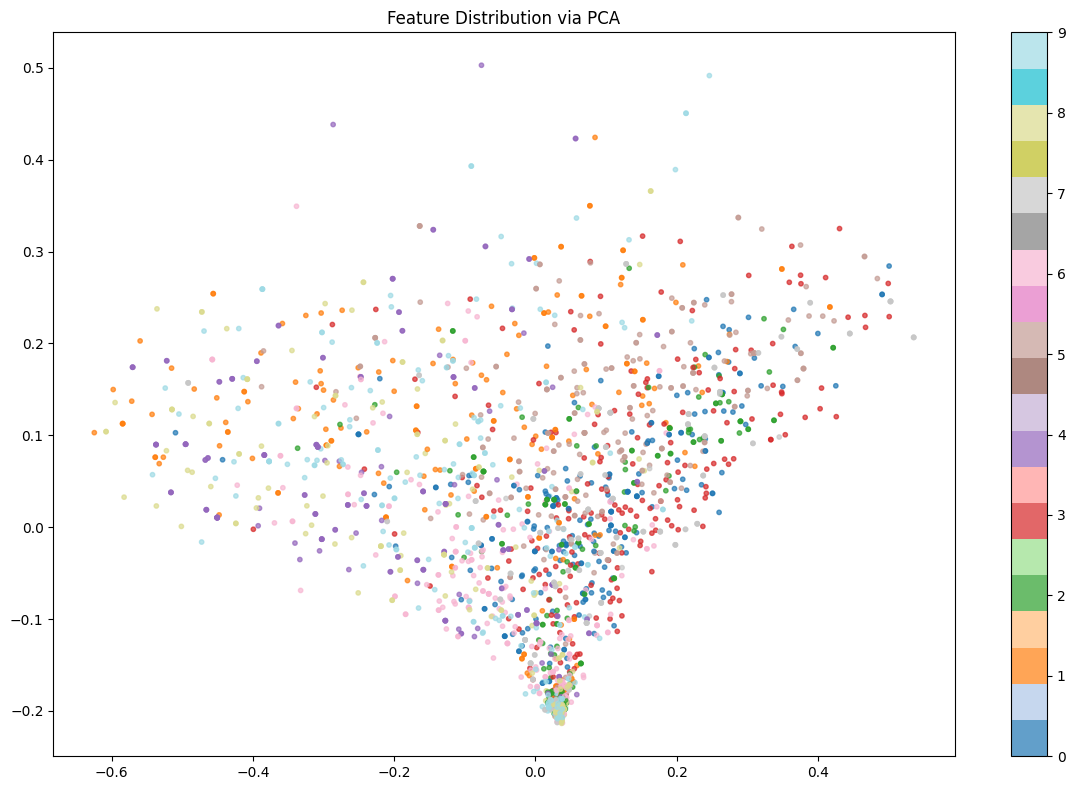

Processing Folds:  20%|██        | 1/5 [00:26<01:46, 26.51s/it]

✔ Fold 0 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 1 ===
[Fold 1] ▶ Original Train: 2272개, Original Test: 568개
[Fold 1] ▶ Resampled Train: 2272개, Test: 568개
  ▶ Train feature extraction (Fold 1)...


  Extracting Train Features (Fold 1): 100%|██████████| 2272/2272 [00:20<00:00, 110.37it/s]


  ✔ Train feature extraction complete for Fold 1. Feature Shape: (2272, 7594)
  ✔ Faiss KNN 모델 학습 완료 (Fold 1).
  ▶ Test feature extraction (Fold 1)...


  Extracting Test Features (Fold 1): 100%|██████████| 568/568 [00:04<00:00, 121.88it/s]


  ✔ Test feature extraction complete for Fold 1. Feature Shape: (568, 7594)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.3768
               precision    recall  f1-score   support

      Bicycle       0.44      0.28      0.34        57
       Bridge       0.45      0.46      0.45        57
          Bus       0.39      0.33      0.36        57
          Car       0.15      0.05      0.08        56
      Chimney       0.44      0.54      0.49        57
   Crosswalks       0.75      0.42      0.54        57
      Hydrant       0.35      0.32      0.33        57
   Motorcycle       0.52      0.58      0.55        57
         Palm       0.22      0.66      0.33        56
Traffic Light       0.35      0.12      0.18        57

     accuracy                           0.38       568
    macro avg       0.41      0.38      0.37       568
 weighted avg       0.41      0.38      0.37       568



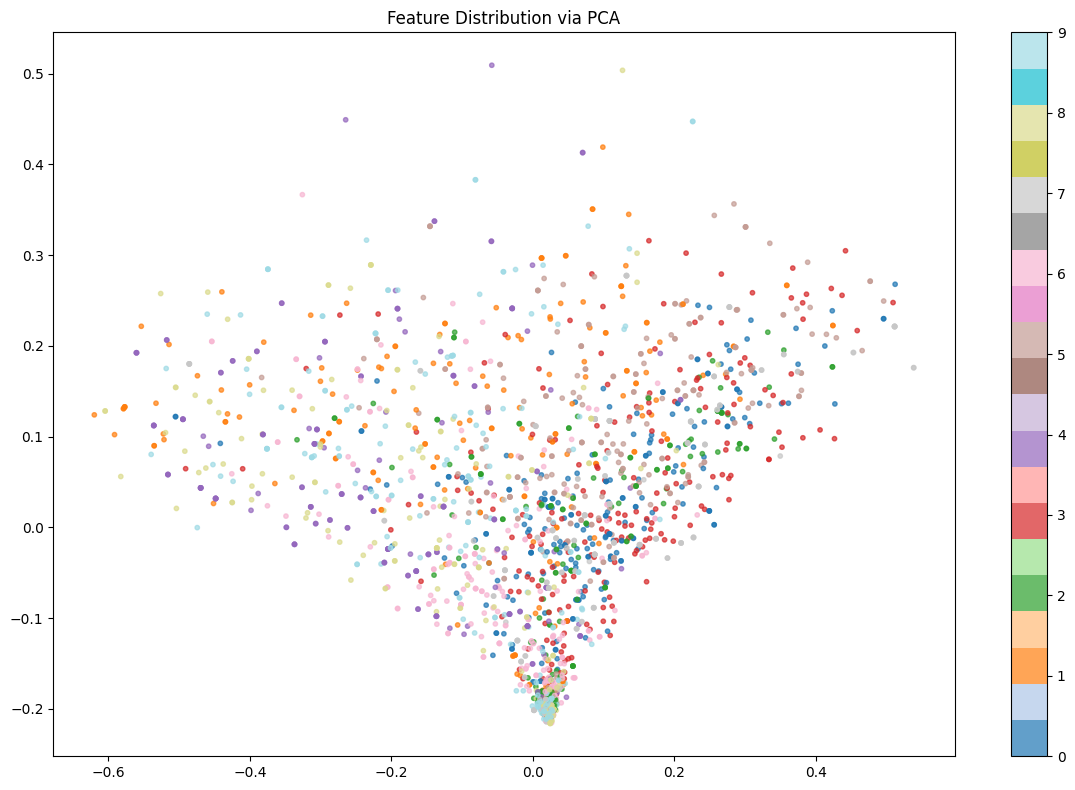

Processing Folds:  40%|████      | 2/5 [00:53<01:19, 26.63s/it]

✔ Fold 1 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 2 ===
[Fold 2] ▶ Original Train: 2272개, Original Test: 568개
[Fold 2] ▶ Resampled Train: 2272개, Test: 568개
  ▶ Train feature extraction (Fold 2)...


  Extracting Train Features (Fold 2): 100%|██████████| 2272/2272 [00:21<00:00, 105.37it/s]


  ✔ Train feature extraction complete for Fold 2. Feature Shape: (2272, 7594)
  ✔ Faiss KNN 모델 학습 완료 (Fold 2).
  ▶ Test feature extraction (Fold 2)...


  Extracting Test Features (Fold 2): 100%|██████████| 568/568 [00:04<00:00, 129.50it/s]


  ✔ Test feature extraction complete for Fold 2. Feature Shape: (568, 7594)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.3310
               precision    recall  f1-score   support

      Bicycle       0.31      0.16      0.21        57
       Bridge       0.42      0.39      0.40        57
          Bus       0.31      0.30      0.31        56
          Car       0.13      0.05      0.07        57
      Chimney       0.36      0.47      0.41        57
   Crosswalks       0.55      0.30      0.39        57
      Hydrant       0.43      0.23      0.30        57
   Motorcycle       0.36      0.73      0.48        56
         Palm       0.23      0.58      0.33        57
Traffic Light       0.38      0.11      0.16        57

     accuracy                           0.33       568
    macro avg       0.35      0.33      0.31       568
 weighted avg       0.35      0.33      0.31       568



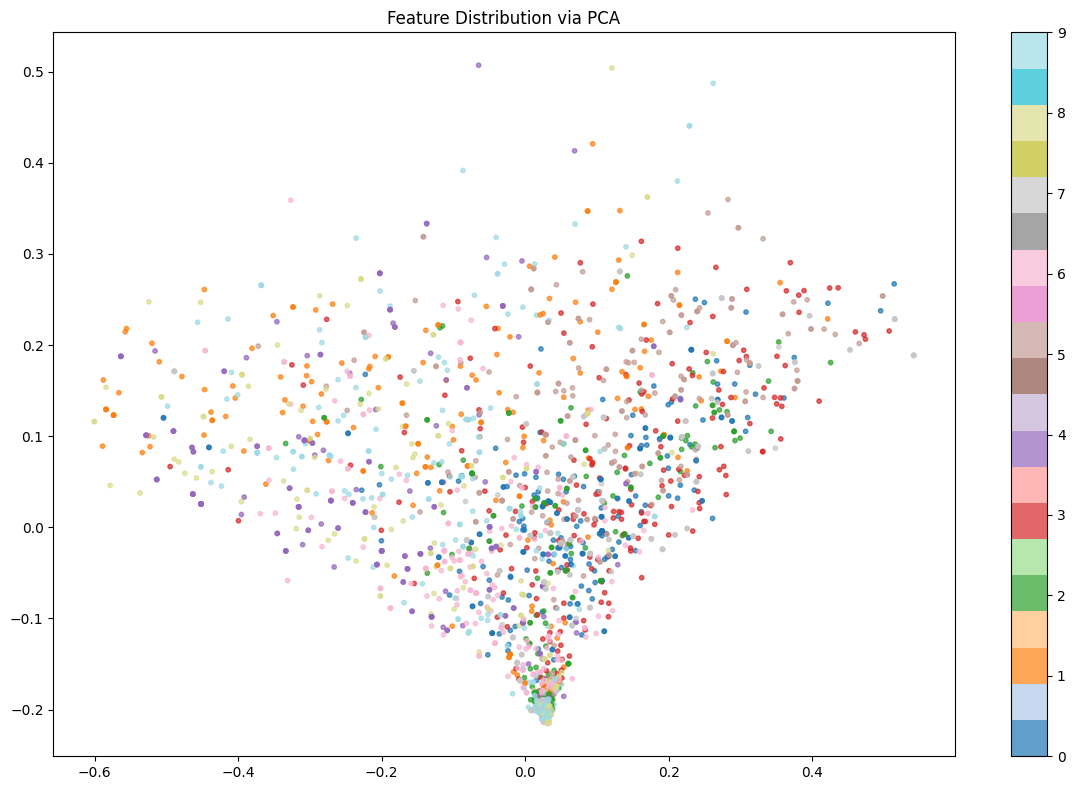

Processing Folds:  60%|██████    | 3/5 [01:20<00:53, 26.93s/it]

✔ Fold 2 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 3 ===
[Fold 3] ▶ Original Train: 2272개, Original Test: 568개
[Fold 3] ▶ Resampled Train: 2272개, Test: 568개
  ▶ Train feature extraction (Fold 3)...


  Extracting Train Features (Fold 3): 100%|██████████| 2272/2272 [00:20<00:00, 108.56it/s]


  ✔ Train feature extraction complete for Fold 3. Feature Shape: (2272, 7594)
  ✔ Faiss KNN 모델 학습 완료 (Fold 3).
  ▶ Test feature extraction (Fold 3)...


  Extracting Test Features (Fold 3): 100%|██████████| 568/568 [00:04<00:00, 130.32it/s]


  ✔ Test feature extraction complete for Fold 3. Feature Shape: (568, 7594)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.3539
               precision    recall  f1-score   support

      Bicycle       0.28      0.19      0.23        57
       Bridge       0.32      0.39      0.35        56
          Bus       0.39      0.30      0.34        57
          Car       0.24      0.11      0.15        57
      Chimney       0.39      0.51      0.44        57
   Crosswalks       0.70      0.37      0.48        57
      Hydrant       0.46      0.29      0.35        56
   Motorcycle       0.44      0.68      0.54        57
         Palm       0.21      0.54      0.30        57
Traffic Light       0.56      0.16      0.25        57

     accuracy                           0.35       568
    macro avg       0.40      0.35      0.34       568
 weighted avg       0.40      0.35      0.34       568



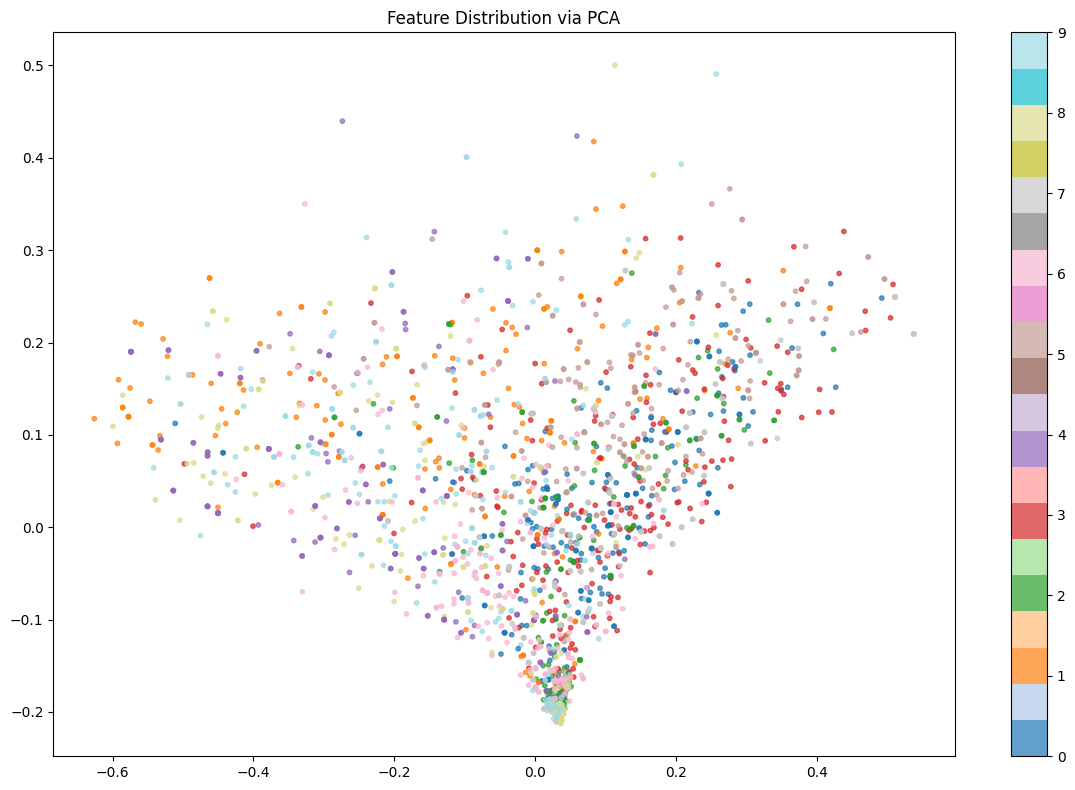

Processing Folds:  80%|████████  | 4/5 [01:47<00:26, 26.88s/it]

✔ Fold 3 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 4 ===
[Fold 4] ▶ Original Train: 2272개, Original Test: 568개
[Fold 4] ▶ Resampled Train: 2272개, Test: 568개
  ▶ Train feature extraction (Fold 4)...


  Extracting Train Features (Fold 4): 100%|██████████| 2272/2272 [00:21<00:00, 105.99it/s]


  ✔ Train feature extraction complete for Fold 4. Feature Shape: (2272, 7594)
  ✔ Faiss KNN 모델 학습 완료 (Fold 4).
  ▶ Test feature extraction (Fold 4)...


  Extracting Test Features (Fold 4): 100%|██████████| 568/568 [00:04<00:00, 138.68it/s]


  ✔ Test feature extraction complete for Fold 4. Feature Shape: (568, 7594)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.3398
               precision    recall  f1-score   support

      Bicycle       0.30      0.16      0.21        56
       Bridge       0.40      0.33      0.36        57
          Bus       0.31      0.28      0.29        57
          Car       0.17      0.09      0.11        57
      Chimney       0.42      0.54      0.47        57
   Crosswalks       0.88      0.38      0.53        56
      Hydrant       0.30      0.19      0.23        57
   Motorcycle       0.47      0.65      0.54        57
         Palm       0.22      0.67      0.33        57
Traffic Light       0.33      0.11      0.16        57

     accuracy                           0.34       568
    macro avg       0.38      0.34      0.32       568
 weighted avg       0.38      0.34      0.32       568



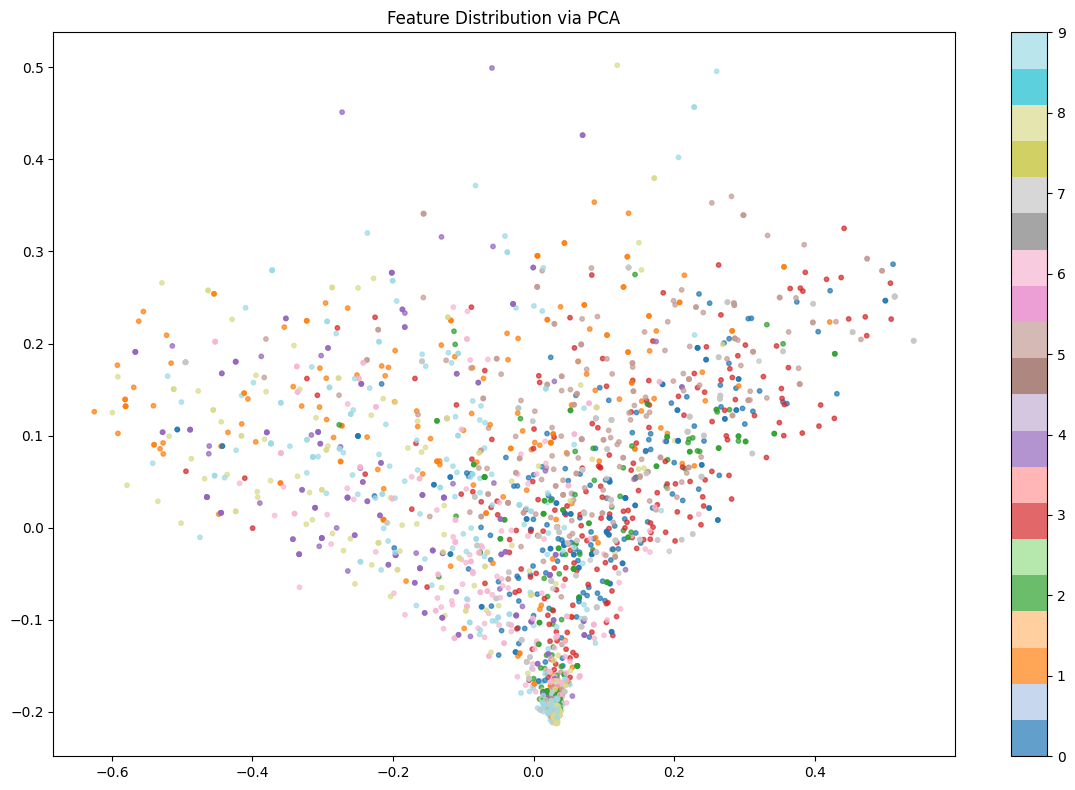

Processing Folds: 100%|██████████| 5/5 [02:14<00:00, 26.81s/it]

✔ Fold 4 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== 5-Fold CV Average ===
Accuracy : 0.3482 ± 0.0160
Precision: 0.3797 ± 0.0214
Recall   : 0.3482 ± 0.0160
F1-Score : 0.3320 ± 0.0206


In [ ]:
# ==============================================================================
#  5-Fold 교차 검증 루프 및 모델 저장
# ==============================================================================
accuracies = []
precisions = []
recalls = []
f1_scores = []

# 모델 저장 경로 설정 (사용자 로컬 PC 내)
# 현재 스크립트가 실행되는 폴더 내에 'image_classification_models' 폴더 생성
MODEL_SAVE_BASE_DIR = 'image_classification_models'
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)
print(f"모델 저장 기본 경로: {os.path.abspath(MODEL_SAVE_BASE_DIR)}")


print("\n=== 5-Fold 교차 검증 시작 ===")
# 중요한 변경: skf.split은 이제 리샘플링되지 않은 원본 images_df를 기준으로 인덱스를 분할합니다.
for i, (train_index, test_index) in tqdm(enumerate(skf.split(images_df_resampled, images_df_resampled['label_encoded'])), # images_df_resampled -> images_df로 변경
                                         total=skf.get_n_splits(), desc="Processing Folds"):
    # 원본 데이터프레임에서 train/test 데이터 분리
    X_train_original = images_df_resampled.iloc[train_index]['image_data'].values
    y_train_original = images_df_resampled.iloc[train_index]['label_encoded'].values
    X_test_original = images_df_resampled.iloc[test_index]['image_data'].values
    y_test_original = images_df_resampled.iloc[test_index]['label_encoded'].values

    print(f"\n=== Fold {i} ===")
    print(f"[Fold {i}] ▶ Original Train: {len(X_train_original)}개, Original Test: {len(X_test_original)}개")

    # --- 중요: 학습 데이터에만 오버샘플링 적용 ---
    #ros = RandomOverSampler(random_state=42) # 또는 SMOTE, ADASYN 사용 가능
    
    # 이미지 데이터를 직접 리샘플링할 수 없으므로, 인덱스를 리샘플링한 후 실제 데이터 매핑
    #train_indices_resampled, y_train_resampled = ros.fit_resample(
     #   np.arange(len(X_train_original)).reshape(-1, 1), # 인덱스만 전달
      #  y_train_original
    #)
    X_train_resampled = X_train_original[y_train_original.flatten()]
    
    f = { # 이제 f 딕셔너리는 폴드별 리샘플링된 학습 데이터와 원본 테스트 데이터를 포함
        'fold': i,
        'X_train': X_train_original,
        'y_train': y_train_original,
        'X_test': X_test_original, # 테스트 세트는 원본 유지
        'y_test': y_test_original,
    }
    print(f"[Fold {f['fold']}] ▶ Resampled Train: {len(f['X_train'])}개, Test: {len(f['X_test'])}개")


    # 1) train set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Train feature extraction (Fold {f['fold']})...")
    X_train_feats = thread_map(
        lambda img: extract_features(preprocess_image(img), sift_bovw_vocabulary),
        f['X_train'],
        max_workers=8,
        desc=f"  Extracting Train Features (Fold {f['fold']})"
    )
    X_train_feats = np.array(X_train_feats)

    print(f"  ✔ Train feature extraction complete for Fold {f['fold']}. Feature Shape: {X_train_feats.shape}")
    
    # Faiss KNN 모델 학습 (Index 생성)
    faiss_model_tuple = train_faiss_knn_cosine(
        X_train_feats,
        f['y_train'],
        n_neighbors=5
    )
    print(f"  ✔ Faiss KNN 모델 학습 완료 (Fold {f['fold']}).")

    # 2) test set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Test feature extraction (Fold {f['fold']})...")
    X_test_feats = thread_map(
        lambda img: extract_features(preprocess_image(img), sift_bovw_vocabulary),
        f['X_test'],
        max_workers=8,
        desc=f"  Extracting Test Features (Fold {f['fold']})"
    )
    X_test_feats = np.array(X_test_feats)

    print(f"  ✔ Test feature extraction complete for Fold {f['fold']}. Feature Shape: {X_test_feats.shape}")
    
    # 평가
    y_pred = test(
        faiss_model_tuple,
        X_test_feats,
        f['y_test'],
        average='weighted'
    )

    visualize_features(X_train_feats, f['y_train'], method='pca')

    # 폴드별 지표 저장
    acc = accuracy_score(f['y_test'], y_pred)
    prec = precision_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    rec  = recall_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    f1   = f1_score(f['y_test'], y_pred, average='weighted', zero_division=0) # F1-score 추가

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    
    # --- 각 폴드별 Faiss 모델 저장 ---
    fold_model_dir = os.path.join(MODEL_SAVE_BASE_DIR, 'knn_faiss_folds')
    os.makedirs(fold_model_dir, exist_ok=True)
    fold_index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{f["fold"]}.bin')
    
    faiss.write_index(faiss_model_tuple[0], fold_index_path)
    joblib.dump(
        {'y_train_labels': faiss_model_tuple[1], 'n_neighbors': faiss_model_tuple[2]},
        os.path.join(fold_model_dir, f'faiss_params_fold_{f["fold"]}.joblib')
    )
    print(f"✔ Fold {f['fold']} Faiss Index and parameters saved to '{fold_model_dir}'.")
    # --- 저장 부분 끝 ---


# 5) 5-fold 평균 지표 출력
print("\n=== 5-Fold CV Average ===")
print(f"Accuracy : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score : {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}") # F1-score 출력 추가

In [ ]:
def test_on_new_dataset(fold_model_dir, X_test_feats, y_test, average='weighted'):
    """
    저장된 5개의 fold별 FAISS 모델을 불러와서 각각 예측하고, 앙상블 결과를 리턴
    - fold_model_dir: 폴드별 모델이 저장된 디렉토리
    - X_test_feats: 새로운 데이터셋의 feature vector (numpy array)
    - y_test: ground truth 라벨
    """
    all_preds = []

    for fold in range(5):
        # 모델 로드
        index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{fold}.bin')
        param_path = os.path.join(fold_model_dir, f'faiss_params_fold_{fold}.joblib')

        faiss_index = faiss.read_index(index_path)
        params = joblib.load(param_path)
        y_train_labels = params['y_train_labels']
        k = params['n_neighbors']

        # 예측 수행
        print(f"\n▶ Fold {fold} 모델 예측 중...")
        y_pred = predict_faiss_knn_cosine(faiss_index, y_train_labels, k, X_test_feats)
        all_preds.append(y_pred)

    # 다수결 앙상블
    all_preds = np.array(all_preds)  # shape: (n_folds, n_samples)
    final_preds = []
    for i in range(all_preds.shape[1]):
        votes = all_preds[:, i]
        unique_labels, counts = np.unique(votes, return_counts=True)
        final_label = unique_labels[np.argmax(counts)]
        final_preds.append(final_label)
    final_preds = np.array(final_preds)

    # 평가
    print("\n=== 앙상블 평가 결과 ===")
    acc = accuracy_score(y_test, final_preds)
    prec = precision_score(y_test, final_preds, average=average, zero_division=0)
    rec = recall_score(y_test, final_preds, average=average, zero_division=0)
    print(f"[Ensemble Accuracy] {acc:.4f}")
    print(classification_report(y_test, final_preds))  # 클래스 이름 지정은 필요시 추가

    return final_preds, acc, prec, rec

In [33]:
# 1. 데이터 로드
fold_model_dir = 'image_classification_models/knn_faiss_folds'
DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/cry2003/google-recaptcha-v2-images/versions/1/"


print("▶ 이미지 데이터 로드 중...")
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    exit()

# 2. 상위 100개 라벨만 선택 (사전순 or 이미지 많은 순)
label_counts = images_df['label'].value_counts()
top_labels = label_counts.head(100).index  # 상위 100개 라벨

images_df = images_df[images_df['label'].isin(top_labels)]

# 3. 라벨별 100개씩 샘플링
images_df = images_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 100), random_state=42)
).reset_index(drop=True)
print(f"✔ 상위 100개 라벨에서 최대 100개씩 샘플링 완료. 총 이미지 수: {len(images_df)}")

# 4. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스 수: {len(le.classes_)}")

# 5. Feature 추출
print("▶ Feature 추출 중...")
X_test_feats = [
    extract_features(preprocess_image(img), sift_bovw_vocabulary)
    for img in tqdm(images_df['image_data'], desc="  Extracting Test Features")
]
X_test_feats = np.array(X_test_feats)
print(f"✔ Feature 추출 완료. Shape: {X_test_feats.shape}")

# 6. 라벨 추출
y_test = images_df['label_encoded'].values

# 7. 앙상블 평가
ensemble_model = EnsembleFaissKNN(fold_model_dir=fold_model_dir)
ensemble_model.load_models()
y_pred = ensemble_model.evaluate(X_test_feats, y_test, le=le)

score = silhouette_score(X_test_feats, y_test)
print("Silhouette Score:", score)


▶ 이미지 데이터 로드 중...


폴더 로드 중: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]
C:\Users\bvb09\AppData\Local\Temp\ipykernel_23672\2220145950.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label', group_keys=False).apply(


✔ 총 29199개의 이미지 로드 완료.
✔ 상위 100개 라벨에서 최대 100개씩 샘플링 완료. 총 이미지 수: 1000
✔ 라벨 인코딩 완료. 클래스 수: 10
▶ Feature 추출 중...


  Extracting Test Features: 100%|██████████| 1000/1000 [00:14<00:00, 70.80it/s]


✔ Feature 추출 완료. Shape: (1000, 7594)
✔ 5개의 Fold 모델 로딩 완료.

=== 앙상블 평가 결과 ===
Accuracy : 0.2270
Precision: 0.2762
Recall   : 0.2270
               precision    recall  f1-score   support

      Bicycle       0.36      0.14      0.20       100
       Bridge       0.33      0.38      0.35       100
          Bus       0.13      0.11      0.12       100
          Car       0.15      0.06      0.09       100
      Chimney       0.28      0.36      0.32       100
    Crosswalk       0.61      0.14      0.23       100
      Hydrant       0.12      0.08      0.10       100
   Motorcycle       0.30      0.38      0.33       100
         Palm       0.15      0.55      0.24       100
Traffic Light       0.32      0.07      0.11       100

     accuracy                           0.23      1000
    macro avg       0.28      0.23      0.21      1000
 weighted avg       0.28      0.23      0.21      1000

Silhouette Score: -0.07404159339560096


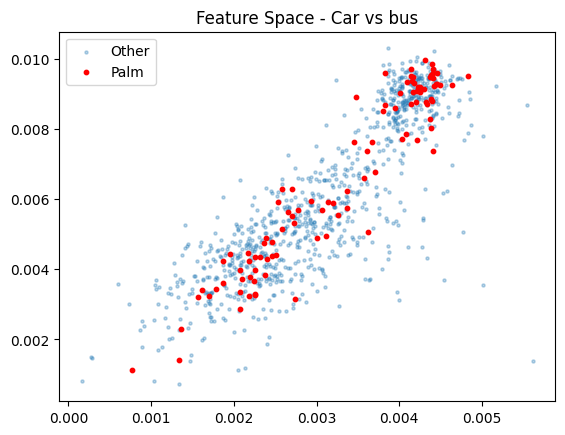

In [38]:
car_indices = np.where(images_df['label'] == 'Palm')[0]
other_indices = np.where(images_df['label'] != 'Palm')[0]

plt.scatter(X_test_feats[other_indices][:, 0], X_test_feats[other_indices][:, 1], alpha=0.3, label='Other', s=5)
plt.scatter(X_test_feats[car_indices][:, 0], X_test_feats[car_indices][:, 1], alpha=1.0, label='Palm', s=10, c='red')
plt.legend()
plt.title("Feature Space - Car vs bus")
plt.show()


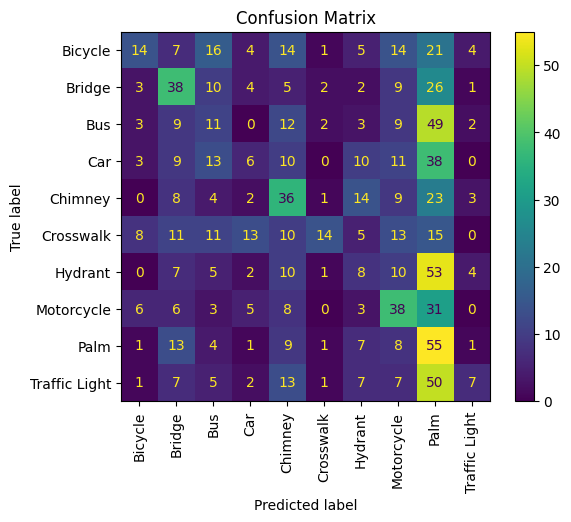

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


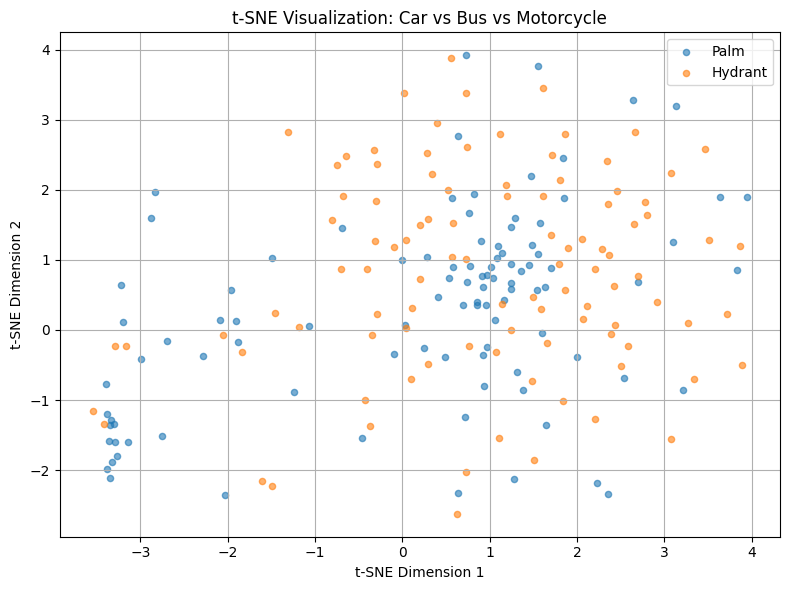

In [ ]:
from sklearn.manifold import TSNE

# 시각화 대상 클래스
target_classes = ['Palm', 'Hydrant']

# 대상 샘플 인덱스 추출
target_indices = images_df[images_df['label'].isin(target_classes)].index

# 대상 feature 및 라벨 추출
subset_feats = X_test_feats[target_indices]
subset_labels = images_df.loc[target_indices, 'label'].values

# t-SNE 변환
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)
subset_feats_2d = tsne.fit_transform(subset_feats)

# 시각화
plt.figure(figsize=(8, 6))
for label in target_classes:
    idx = subset_labels == label
    plt.scatter(subset_feats_2d[idx, 0], subset_feats_2d[idx, 1], label=label, alpha=0.6, s=20)

plt.title("t-SNE Visualization: Car vs Bus vs Motorcycle")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
